In [31]:
import pyspark
import pandas as pd

In [2]:
sc = pyspark.SparkContext(appName="teste")

In [3]:
sc

<SparkContext master=local[*] appName=teste>

In [4]:
sc.parallelize(range(1000)).count()

1000

In [5]:
rdd = sc.sequenceFile("web_brasil_small/part-00000") #rdd = sc.textFile("web_brasil_small/part-00000")

In [6]:
rdd.count()

36133

In [7]:
rdd.filter(lambda x: "fiscal" in x[1]).count()

1162

In [8]:
rdd.take(1)

[('https://sebodomessias.com.br/suas_compras.aspx?retirar=0&action=1&idItem=2023136',
  'Sebo do Messias - Suas Compras\nLivroDVDCDLPGibiRevista\n|\nBusca avancada\nBem-vindo ao\nSebo do Messias.\nFaça o seu LOGIN\nMinha conta\nAlterar senha\nAlterar Email\nMeu Carrinho\nHistórico de Pedidos\nMeus Interesses\nSair\n1\nNão possui conta?\nCadastre-se\nOlá, seja bem-vindo!\n×\nPara prosseguir, por favor identifique-se utilizando os campos abaixo e depois clique no botão “ENTRAR”.\nE-mail\nSenha\nEsqueci minha senha\nEsqueceu sua senha?\n×\nPreencha o seu email no campo abaixo e clique no botão "ENVIAR".\nE-mail\nFaça seu login\nConfirmado!\n×\nEnviamos uma mensagem em seu e-mail para alteração de senha.\n(se não encontra-lo, verifique sua caixa de spam).\nFaça seu login\nNão possui conta?\nCadastre-se\nBusca Avançada\n×\nIndique as opções relevantes a sua busca.\nBusca por: LivroDVDCDLPGibiRevista\nÁlbum:\nArtista / Banda:\nAno:\nGravadora: Selecione uma Gravadora32 Blues4adABKCOABRIL MUS

In [9]:
import math


def conta_palavras_em_doc(item):
    url, text = item
    words = text.strip().split()
    return [(word.lower(), 1) for word in set(words)] # set() -> contagem de documentos que a palavra aparece

def junta_contagens(nova_contagem, contagem_atual):
    return nova_contagem + contagem_atual

def computa_relevancia(item):
    palavra, valor = item
    freq, idf = valor
    relevancia = freq*idf
    return (palavra, relevancia)
    
def conta_palavras_total(item):
    url, text = item
    words = text.strip().split()
    return [(word.lower(), 1) for word in words]

def filtra_doc_freq(item):
    palavra, contagem = item
    return (contagem < DOC_COUNT_MAX) and (contagem >= DOC_COUNT_MIN)

def sort_100(item):
    palavra, relevancia = item
    return 

def computa_idf(item):
    palavra, contagem = item
    idf = math.log10(N / contagem)
    return(palavra, idf)

def computa_freq(item):
    palavra, contagem = item
    freq = math.log10(1+contagem)
    return(palavra, freq)

def encontra_palavra(item, palavra):
    url, text = item
    words = text.strip().split()
    words_list = [word.lower() for word in words]
    if palavra in words_list:
        return [item]
    return []

def encontra_palavra1(item):
    return encontra_palavra(item, palavra1)

def encontra_palavra2(item):
    return encontra_palavra(item, palavra2)

In [10]:
url, text = rdd.take(1)[0]
url

'https://sebodomessias.com.br/suas_compras.aspx?retirar=0&action=1&idItem=2023136'

In [11]:
rdd_word_freq = rdd.flatMap(conta_palavras_total).reduceByKey(junta_contagens)

In [12]:
rdd_word_freq.take(10)

[('login', 11306),
 ('senha', 8876),
 ('no', 208400),
 ('e-mail', 24013),
 ('esqueci', 1585),
 ('"enviar".', 5),
 ('confirmado!', 12),
 ('spam).', 8),
 ('musicatração', 4),
 ('musicb-uniquebama', 4)]

# Início do estudo

In [13]:
N = rdd.count()

DOC_COUNT_MIN = 10
DOC_COUNT_MAX = N * 0.7

palavra1 = 'boulos'
palavra2 = 'covas'

In [14]:
rdd_palavra1 = rdd.flatMap(encontra_palavra1)
rdd_palavra2 = rdd.flatMap(encontra_palavra2)

In [15]:
rdd_palavra1.count()

79

In [16]:
rdd_palavra2.count()

125

In [17]:
rdd_palavra_intersection = rdd_palavra1.intersection(rdd_palavra2)
rdd_palavra_intersection.count()

15

# IDF

In [18]:
rdd_doc_count_intersection = rdd_palavra_intersection.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)

rdd_idf = rdd_doc_count_intersection.map(computa_idf)

In [19]:
rdd_idf.take(10)

[('tem', 3.4117759853793284),
 ('das', 3.4117759853793284),
 ('no', 3.1599640123855286),
 ('eleições', 3.3274550996792924),
 ('últimas', 3.4117759853793284),
 ('foi', 3.516511335899341),
 ('direitos', 3.516511335899341),
 ('federal', 3.3274550996792924),
 ('ser', 3.557904021057566),
 ('tempo', 3.4439606687507296)]

# COMPUTA FREQ

In [20]:
rdd_words_count = rdd_palavra_intersection.flatMap(conta_palavras_total).reduceByKey(junta_contagens)

rdd_words_freq = rdd_words_count.map(computa_freq)

In [21]:
rdd_words_freq.take(10)

[('pra', 0.8450980400142568),
 ('culturais', 0.47712125471966244),
 ('eleições', 1.6532125137753437),
 ('r$', 1.6232492903979006),
 ('cargos', 0.6020599913279624),
 ('celso', 1.1139433523068367),
 ('tatto-pt,', 0.3010299956639812),
 ('helou', 0.3010299956639812),
 ('vereadores', 0.6020599913279624),
 ('mesmo', 1.3222192947339193)]

# TABELA 1

In [22]:
rdd_join = rdd_words_freq.join(rdd_idf)

In [23]:
rdd_relevancia = rdd_join.map(computa_relevancia)

In [24]:
rdd_relevancia.take(10)

[('eleições', 5.50099040981539),
 ('tem', 5.672957239632598),
 ('foi', 6.252889028917671),
 ('federal', 5.624051565948827),
 ('direito', 4.4806961339316835),
 ('após', 4.623250913590592),
 ('nacional', 5.6608551631019575),
 ('ibope', 4.628939853089387),
 ('tudo', 4.801372280866914),
 ('cultura', 5.092654892097355)]

In [25]:
list_relevance = list(rdd_relevancia.collect())
list_relevance = sorted(list_relevance, key=lambda x: -x[1])[:100]
print(list_relevance)

[('de', 10.610612200301492), ('do', 9.800717471366696), ('da', 9.159126706059979), ('que', 8.99533534582011), ('e', 8.955544782858333), ('o', 8.692833980987029), ('a', 8.637625746364574), ('dos', 8.011809207342987), ('em', 7.944481383334526), ('para', 7.710707314239869), ('são', 7.4578979186704615), ('um', 7.391517758317852), ('uma', 7.288942917901919), ('no', 7.2780166549169785), ('com', 7.163931823164749), ('paulo', 7.0795601711331395), ('os', 6.977411718022709), ('é', 6.948667452837545), ('se', 6.930374801996896), ('das', 6.9238028378247805), ('as', 6.851823693307829), ('na', 6.849452868760334), ('não', 6.8292053209579135), ('por', 6.796136892456971), ('mais', 6.609447313098069), ('-', 6.516299393221553), ('silva', 6.509970968948924), ('brasil', 6.499532429446032), ('como', 6.421909755270102), ('ao', 6.419840034252641), ('rio', 6.375130369637926), ('à', 6.3747904900398895), ('às', 6.326491483788505), ('foi', 6.252889028917671), ('tv', 6.235233791996123), ('2020', 6.210667557956697),

# TABELA 2a

In [26]:
rdd_doc_count_palavra1 = rdd_palavra1.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)
rdd_idf_palavra1 = rdd_doc_count_palavra1.map(computa_idf)

rdd_words_count_palavra1 = rdd_palavra1.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_words_freq_palavra1 = rdd_words_count_palavra1.map(computa_freq)

#rdd_words_count_palavra1.take(10)
rdd_join_palavra1 = rdd_words_freq_palavra1.join(rdd_idf_palavra1)
rdd_relevancia_palavra1 = rdd_join_palavra1.map(computa_relevancia)

list_relevance_palavra1 = list(rdd_relevancia_palavra1.collect())
list_relevance_palavra1 = sorted(list_relevance_palavra1, key=lambda x: -x[1])[:100]
list_relevance_palavra1

[('de', 9.904342937566444),
 ('que', 9.54466457793127),
 ('e', 9.453183634823029),
 ('do', 9.255957383310891),
 ('responder', 9.240051543040362),
 ('da', 8.88391530929072),
 ('a', 8.864479493710792),
 ('o', 8.822388524695747),
 ('-', 8.720054354070509),
 ('josé', 8.517710994474966),
 ('é', 8.46695486205857),
 ('não', 8.414843619699552),
 ('um', 8.367676081238338),
 ('carlos', 8.365634912564511),
 ('se', 8.226392586764593),
 ('para', 8.200731551810788),
 ('uma', 8.165011047502126),
 ('em', 8.149475280989224),
 ('dos', 8.128136720378901),
 ('luiz', 8.117785343280943),
 ('com', 7.992181920514964),
 ('por', 7.962381009462169),
 ('há', 7.915630744962943),
 ('eu', 7.90306651627523),
 ('maria', 7.881491019858184),
 ('ser', 7.870272872121708),
 ('joão', 7.850794533048117),
 ('no', 7.7836695890351),
 ('horas', 7.775740365883516),
 ('mas', 7.724558457860731),
 ('como', 7.722539407550116),
 ('isso', 7.625056813570492),
 ('costa', 7.6125575333114375),
 ('ou', 7.5969311419751655),
 ('na', 7.5559919

# TABELA 2b

In [27]:
rdd_doc_count_palavra2 = rdd_palavra2.flatMap(conta_palavras_em_doc).reduceByKey(junta_contagens).filter(filtra_doc_freq)
rdd_idf_palavra2 = rdd_doc_count_palavra2.map(computa_idf)


rdd_words_count_palavra2 = rdd_palavra2.flatMap(conta_palavras_total).reduceByKey(junta_contagens)
rdd_words_freq_palavra2 = rdd_words_count_palavra2.map(computa_freq)

rdd_join_palavra2 = rdd_words_freq_palavra2.join(rdd_idf_palavra2)
rdd_relevancia_palavra2 = rdd_join_palavra2.map(computa_relevancia)

list_relevance_palavra2 = list(rdd_relevancia_palavra2.collect())
list_relevance_palavra2 = sorted(list_relevance_palavra2, key=lambda x: -x[1])[:100]
list_relevance_palavra2

[('arquivo', 11.04119207813177),
 ('de', 10.209203019902617),
 ('histórico', 9.640264129292504),
 ('do', 9.591189455783677),
 ('2010', 9.445314525710998),
 ('parque', 9.422656525880031),
 ('jardim', 9.275399349291558),
 ('responder', 9.265689011026405),
 ('documentação', 9.189012678164481),
 ('instituto', 9.151030329867657),
 ('da', 9.13294199599167),
 ('e', 9.126022965228016),
 ('municipal', 8.978912532166243),
 ('centro', 8.955966880448162),
 ('memória', 8.869540473920267),
 ('que', 8.794239615778235),
 ('novembro', 8.710537642763951),
 ('público', 8.634430921327267),
 ('museu', 8.58789101720313),
 ('circunscrição', 8.46036597693076),
 ('rio', 8.436949048560622),
 ('fundação', 8.410755376446868),
 ('auditoria', 8.354742985773289),
 ('regional', 8.331428980559933),
 ('i', 8.331374419775244),
 ('sul', 8.321177231484564),
 ('federal', 8.314692471532636),
 ('morre', 8.311309469401246),
 ('às', 8.273513615254544),
 ('a', 8.272783249787269),
 ('vila', 8.240562043862072),
 ('o', 8.191410161

In [36]:
df_palavra1 = pd.DataFrame(list_relevance_palavra1, columns =['Palavra', 'Relevância']) 
df_palavra2 = pd.DataFrame(list_relevance_palavra2, columns =['Palavra', 'Relevância']) 
df_palavra_intersect = pd.DataFrame(list_relevance, columns =['Palavra', 'Relevância']) 

In [38]:
#df_palavra1.to_csv("ResultadoPalavra1.csv")
#df_palavra2.to_csv("ResultadoPalavra2.csv")
#df_palavra_intersect.to_csv("ResultadoIntersect.csv")

In [43]:
def Convert(tup):
    di = {}
    for a, b in tup: 
        di[a] = b 
    return di 

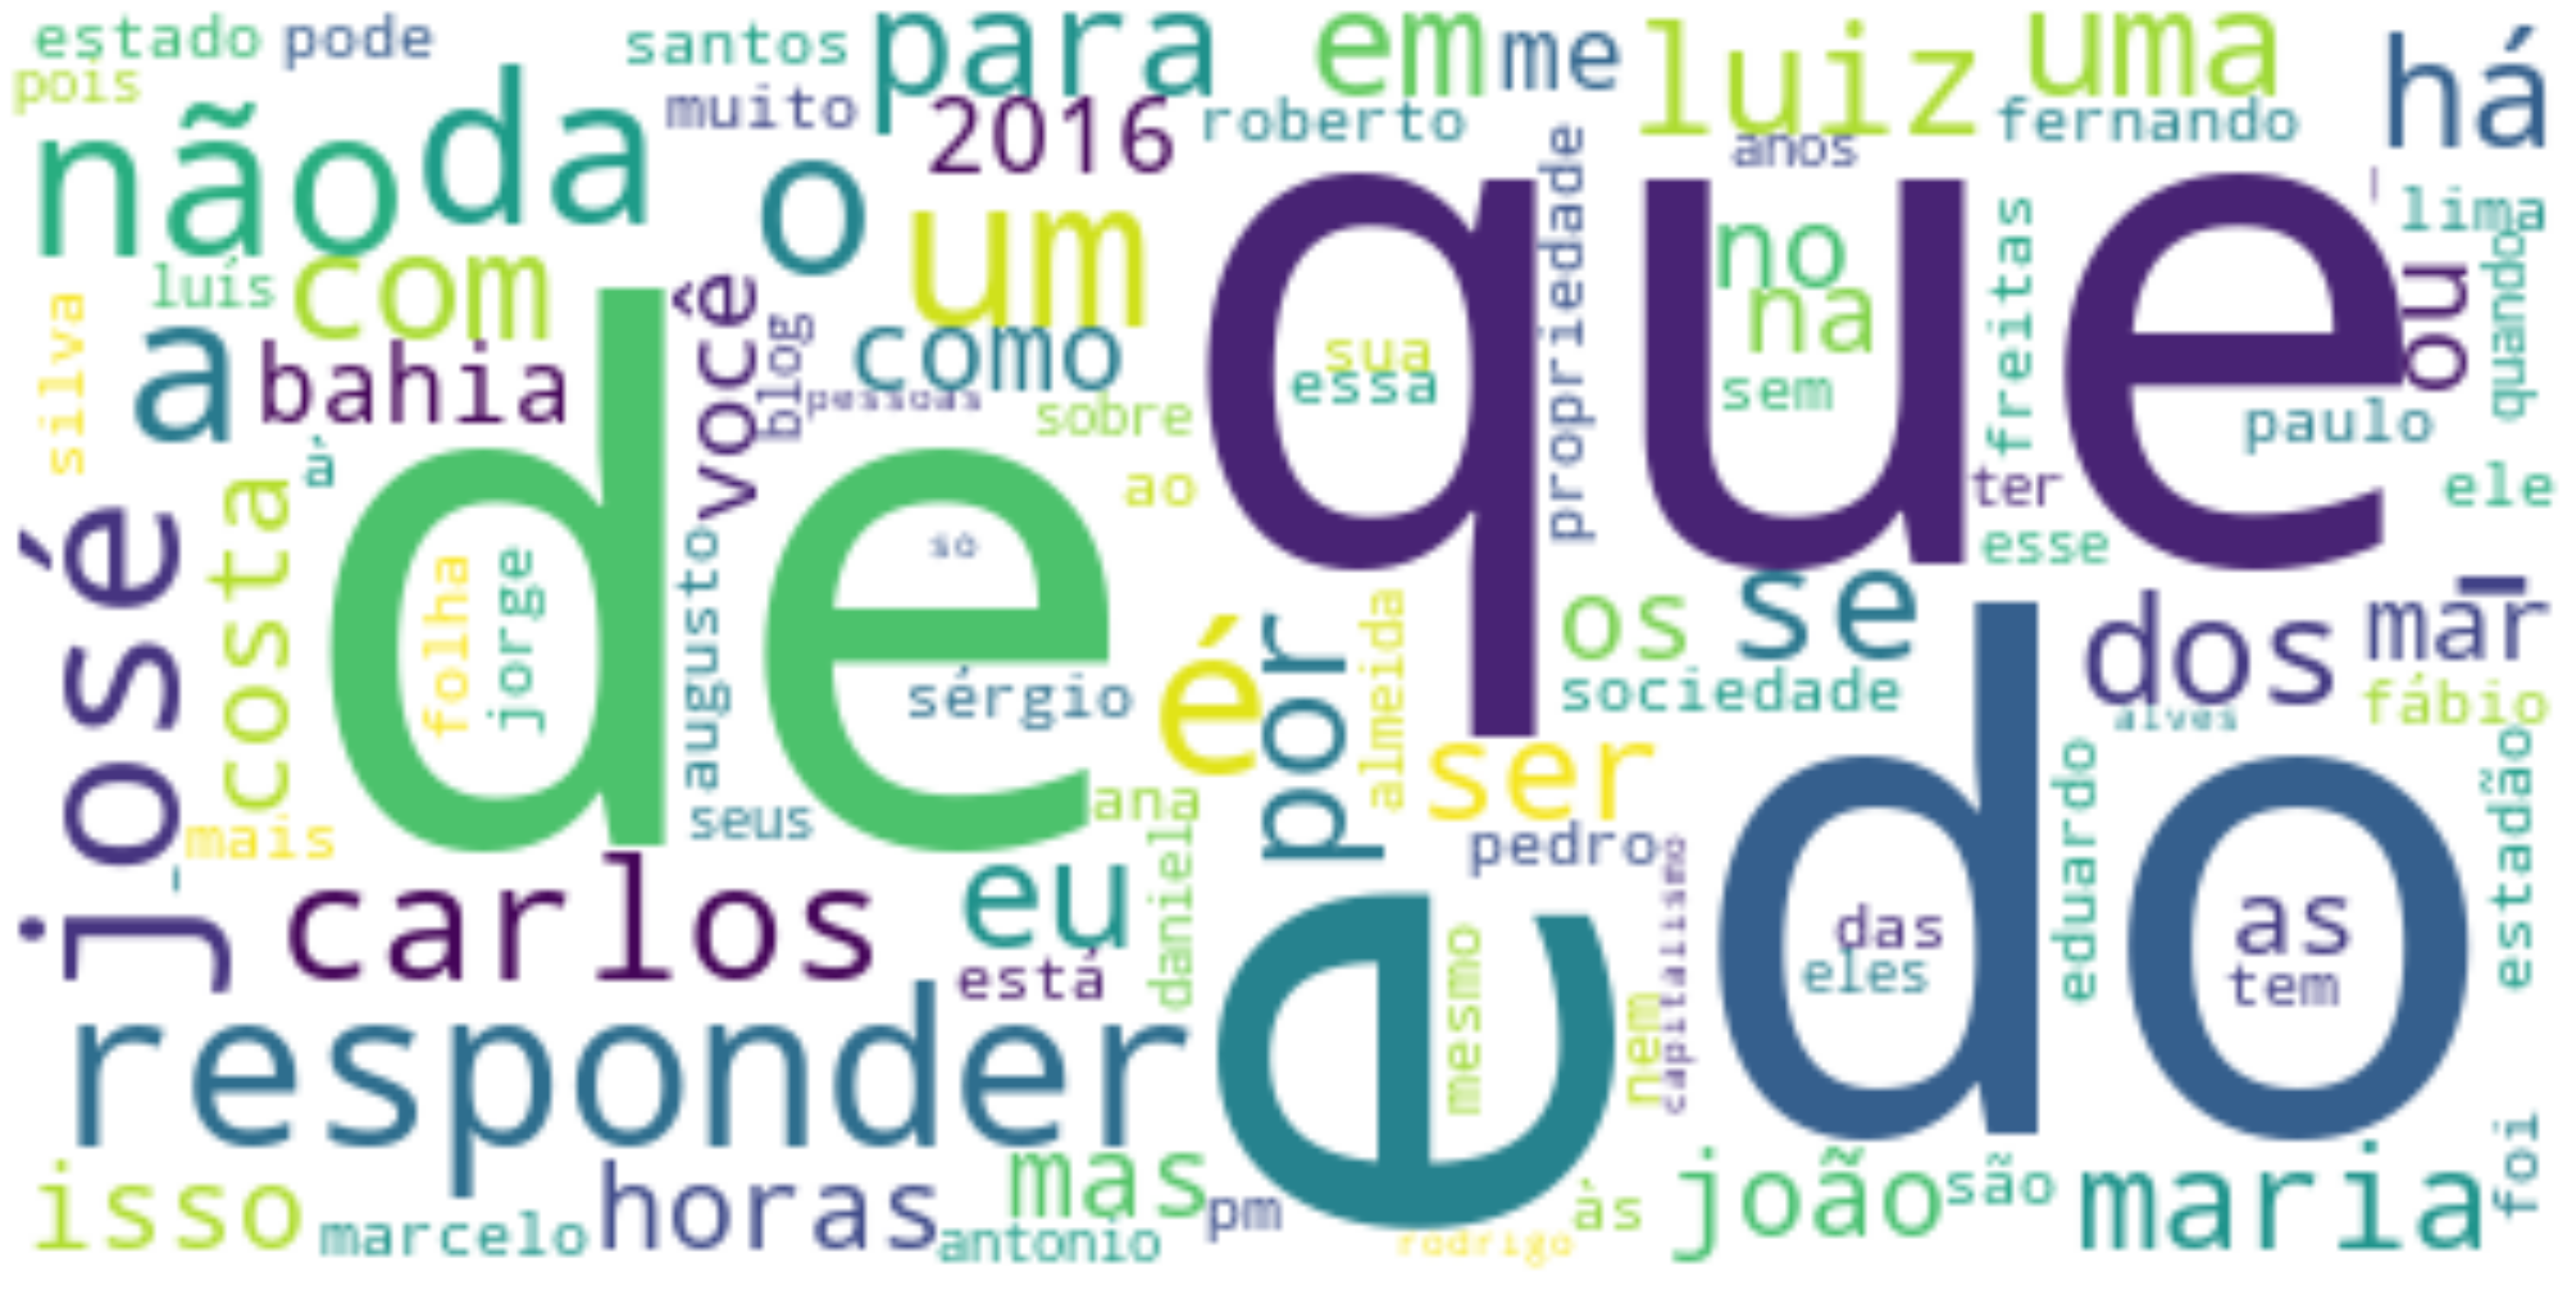

Boulos


In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance_palavra1))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Boulos")

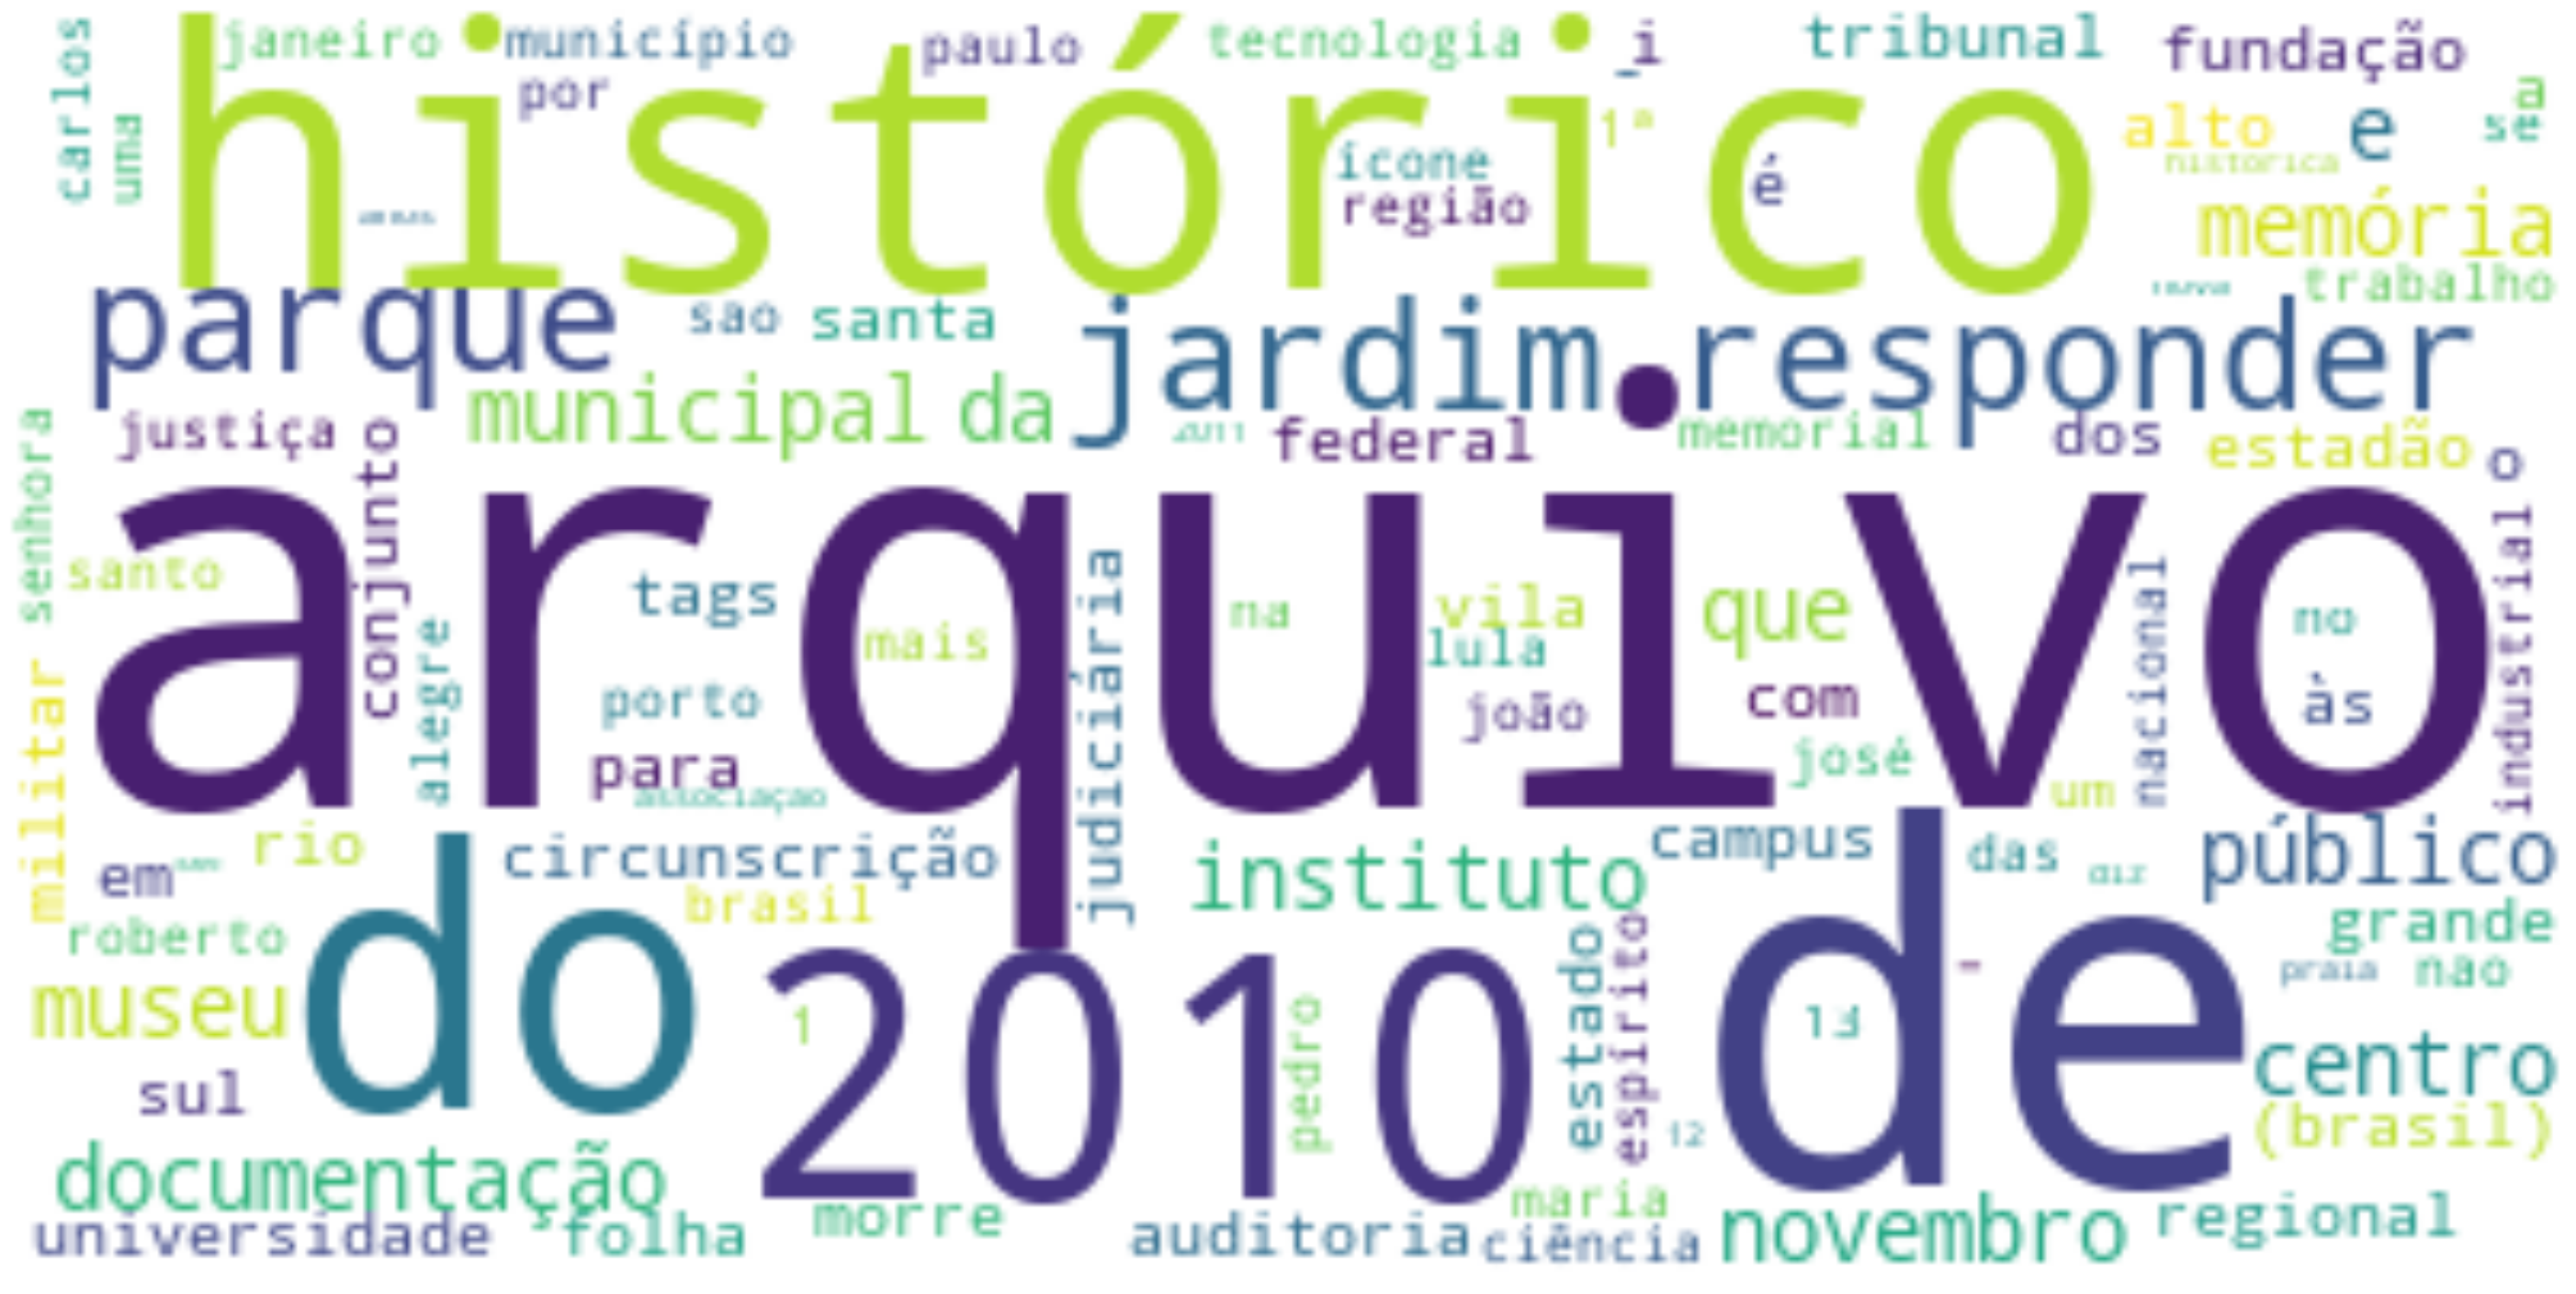

Covas


In [63]:
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=Convert(list_relevance_palavra2))
plt.figure(figsize = (50,50))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
print("Covas")